<a href="https://colab.research.google.com/github/it-dieuanh/Predicting-the-Wear-and-Tear-of-Industrial-Machinery-By-MachineLearning/blob/main/Industrial_Machinery_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df_X = pd.read_csv('/content/X_train.csv')
df_y = pd.read_csv('/content/y_train.csv')

print(df_X.head())
print(df_y.head())

   cat1         num7          num1          num2         num8  cat2  cat3  \
0    18  3002.615162  6.844050e+05  5.438812e+05  1984.083468     3     2   
1    23  1753.001446  9.696060e+05  3.536075e+06  1616.969212     3     2   
2    23  2534.010019  1.518483e+06  5.372982e+06  1984.083468     3     2   
3    28  2846.413447  1.238664e+06  1.468111e+06  1800.526340     3     2   
4    33  2846.413447  1.486196e+06  3.328124e+06  1616.969212     3     2   

   cat4  cat5          num3          num4   cat6  cat7    cat8         num9  \
0    23    66  5.906644e+05  1.497083e+05  14005     5  490516  5976.987619   
1    35    58  9.573292e+05  1.422117e+03  13704     5  490281  5957.691379   
2    23    66  1.499355e+06  1.422117e+03  13907     5  490461  5931.756421   
3    23    50  7.128860e+05  8.911393e+05  13767     5  490721  5966.821025   
4    23    58  7.607118e+05  1.234051e+06  13858     5  490361  5987.458534   

          num10          num5          num6         num11     

_______________________________________________________________________
# **Feature Engineering**


In [ ]:
#Delete NaN Rows in Y -> Avoid Data Leakage
nan_index = df_y.columns[df_y.isna().any()].tolist()
X= df_X.drop(nan_index, axis=1)
y=  df_y.drop(nan_index, axis=1)


In [ ]:
#Delete NaN Val in X

X.drop(['num12'], axis =1 , inplace = True)

print(X.shape)
print(y.shape)


(17479, 19)
(17479, 1)


In [ ]:
# prompt: sort by columns name of X

X = X.sort_index(axis=1)
# print(X.head())


____________________________________________________________________
# **Data Analysis**

In [ ]:
def visualize_data(X):
  fig, axes = plt.subplots(nrows=5, ncols= 4, figsize=(12, 10))
  for n, cols in enumerate(X):
    axs = axes[n//4, n%4]
    sns.histplot(data = X, x= cols, ax=axs)
    axs.set_title(cols)

  plt.tight_layout()
  plt.show()




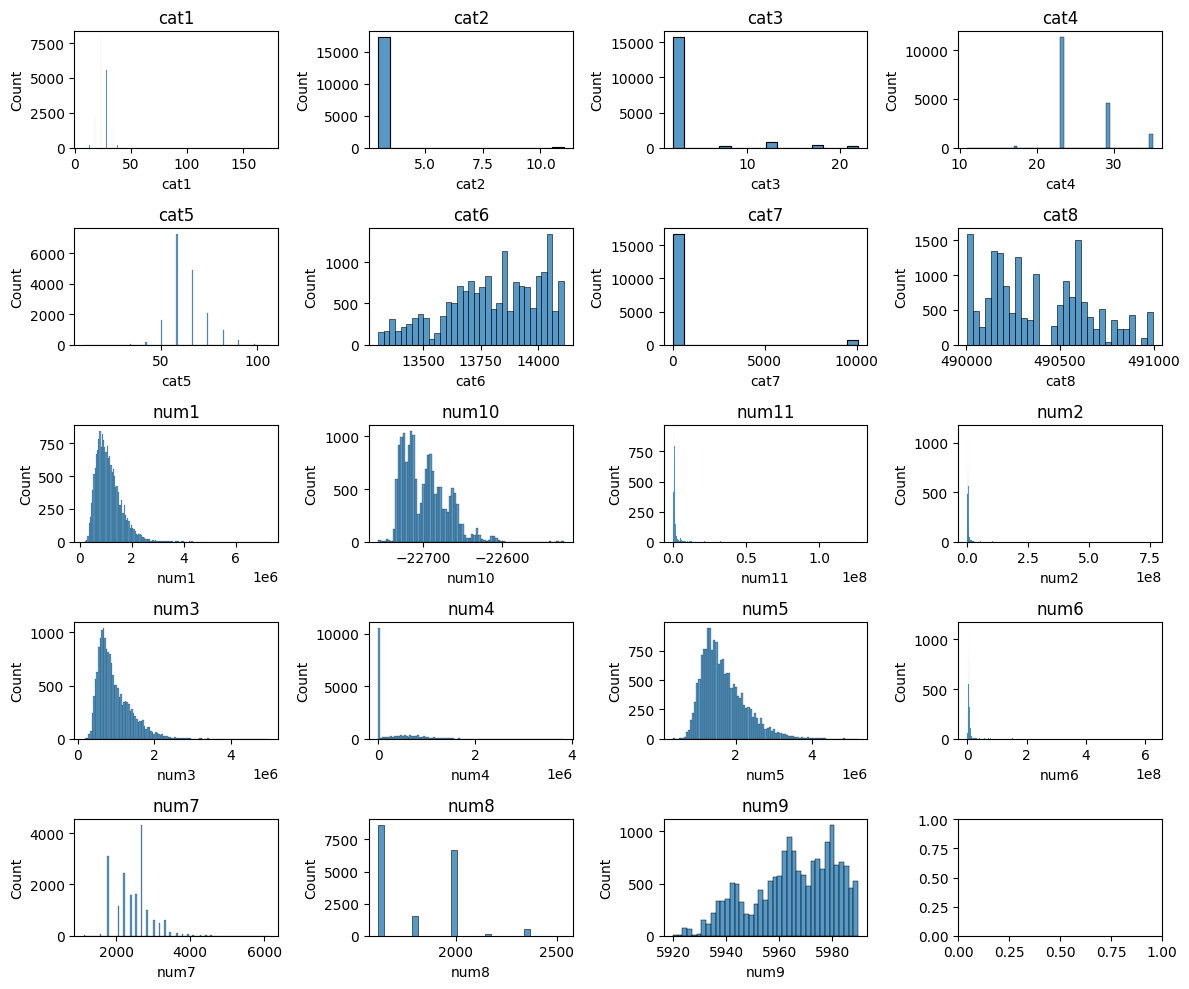

In [ ]:
visualize_data(X)

Nhận xét là các giá trị num đang bị mất cân bằng

In [ ]:

def log_transform(df):
  for col in df.columns:
    if df[col].max() - df[col].min() >= 10000 and df[col].min()>0:
      df[col] = np.log2(df[col]) # Use log1p to handle zero values
  return df



In [ ]:
from sklearn.preprocessing import StandardScaler

def transform_data(X):
  X_temp= X.copy()
  X_temp = log_transform(X_temp)
  scaler = StandardScaler()
  X_temp = pd.DataFrame(scaler.fit_transform(X_temp))
  X_temp.columns = X.columns
  return X_temp


X= transform_data(X)


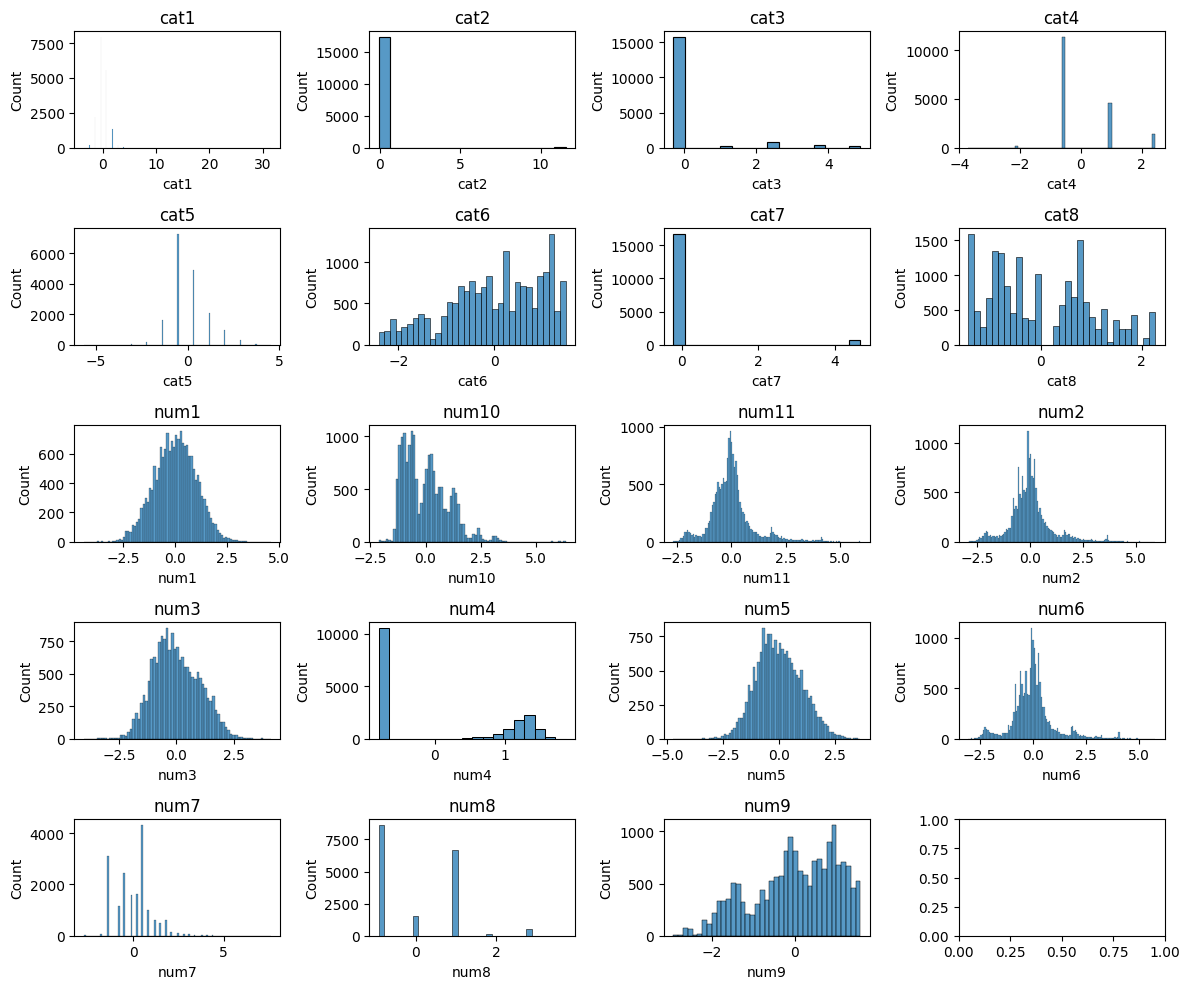

In [ ]:
visualize_data(X)


**Mutual Info**

In [ ]:
# from sklearn.feature_selection import mutual_info_regression



# def make_mi_scores(X, y):
#     mi_scores = mutual_info_regression(X, y)
#     mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
#     mi_scores = mi_scores.sort_values(ascending=False)
#     return mi_scores

# mi_scores = make_mi_scores(X, y)
# # print(mi_scores)  # show a few features with their MI scores

In [ ]:
# def plot_scores(scores, name):
#     scores = scores.sort_values(ascending=True)
#     width = np.arange(len(scores))
#     ticks = list(scores.index)
#     plt.barh(width, scores)
#     plt.yticks(width, ticks)
#     plt.title(name)


# plt.figure(dpi=100, figsize=(8, 5))
# plot_scores(mi_scores, "Mutual Information Scores")

# **Train Model**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Random forest

In [ ]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor()

Nhận xét: Model RandomForest train chậm

Hyper parameters tuning

In [ ]:
# prompt: stacking regressor from different models and find best meta_model

from sklearn.linear_model import LassoCV, ElasticNetCV

# Define a list of potential meta-learners
meta_learners = [
    LinearRegression(),
    RidgeCV(),
    LassoCV(),
    ElasticNetCV(),
    SVR(),
    RandomForestRegressor(random_state=42)
]

best_meta_learner = None
best_rmse = float('inf')

for meta_learner in meta_learners:
    stacking_regressor = StackingRegressor(
        estimators=estimators, final_estimator=meta_learner
    )
    stacking_regressor.fit(X_train, y_train.values.ravel())
    stacking_pred = stacking_regressor.predict(X_test)
    stacking_rmse = root_mean_squared_error(y_test, stacking_pred)
    print(f"Stacking Regressor with {type(meta_learner).__name__} RMSE: {stacking_rmse}")

    if stacking_rmse < best_rmse:
        best_rmse = stacking_rmse
        best_meta_learner = meta_learner

print(f"\nBest Meta-learner: {type(best_meta_learner).__name__} with RMSE: {best_rmse}")


Stacking Regressor with LinearRegression RMSE: 136.8038434712287
Stacking Regressor with RidgeCV RMSE: 136.80389991357634
Stacking Regressor with LassoCV RMSE: 137.007869315182
Stacking Regressor with ElasticNetCV RMSE: 137.0430069458639
Stacking Regressor with SVR RMSE: 250.53015254807082
Stacking Regressor with RandomForestRegressor RMSE: 144.06703306439593

Best Meta-learner: LinearRegression with RMSE: 136.8038434712287


Hyper paramter tuning

In [ ]:
# #Thống kê
# plt.figure(figsize=(10,3))
def print_score(model):
  y_pred = model.predict(X_test)
  return root_mean_squared_error(y_test, y_pred)



51.07472451560942
141.96727753470384


# **FINAL**

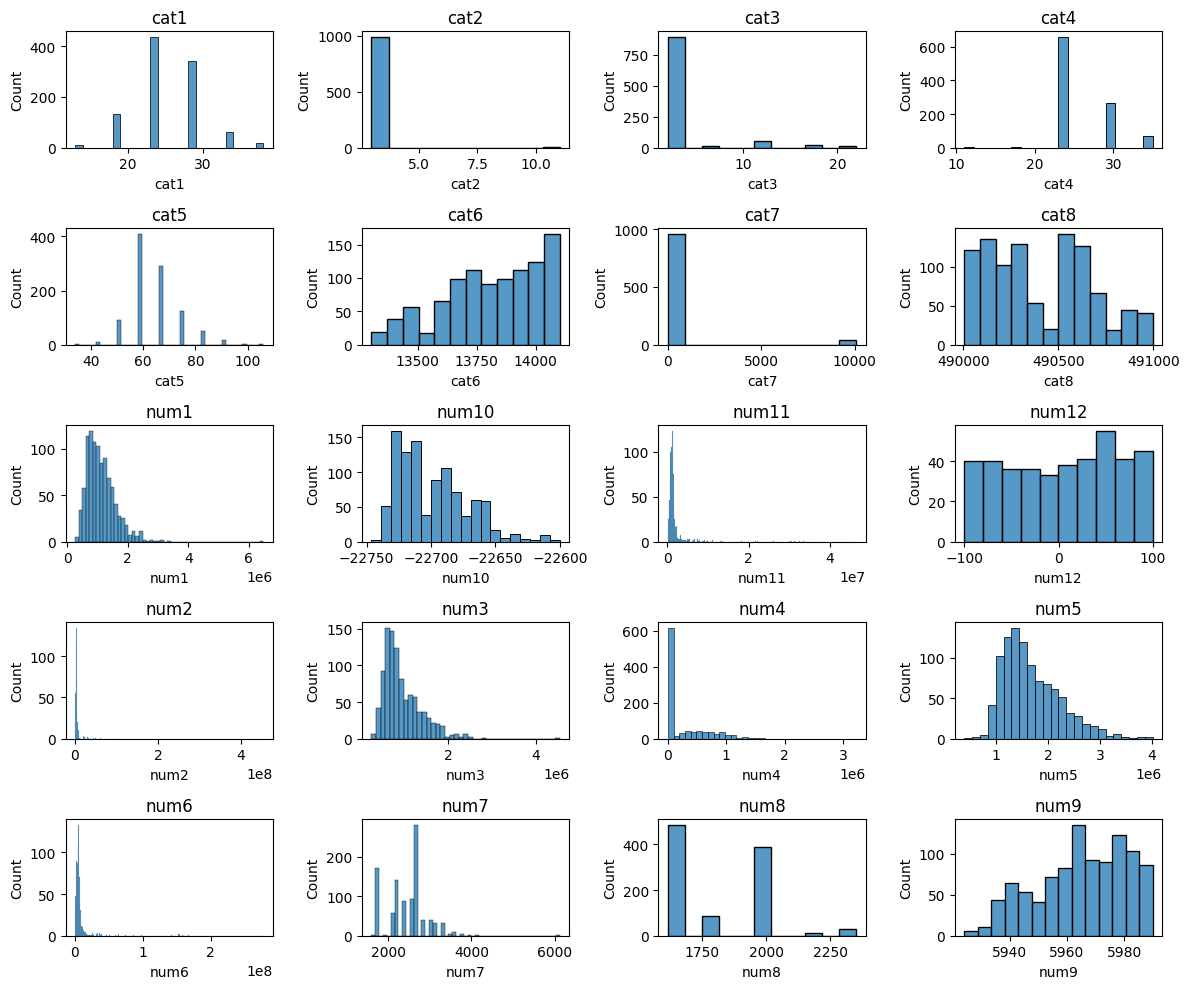

______________________________________________


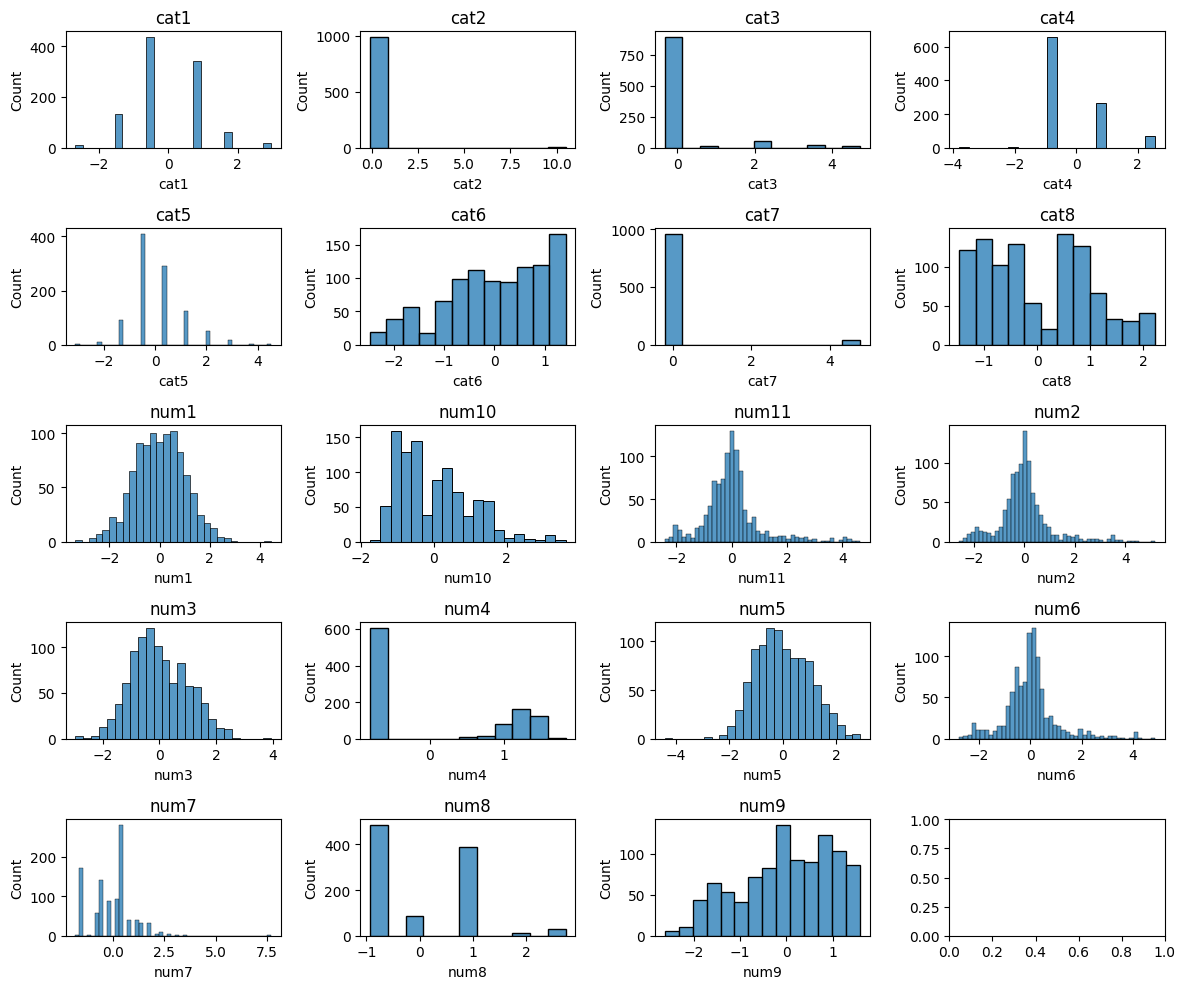

In [ ]:
X_public_test = pd.read_csv('/content/X_public_test.csv')
X_public_test = X_public_test.sort_index(axis=1)
visualize_data(X_public_test)

print("______________________________________________")

X_public_test.drop(['num12'], axis =1 , inplace = True)
X_public_test= transform_data(X_public_test)
visualize_data(X_public_test)

In [ ]:
from google.colab import files


def create_file(model):
  model.fit(X,y)
  X_public_pred = pd.DataFrame(model.predict(X_public_test))
  X_public_pred.columns = y.columns
  X_public_pred.to_csv('predictions.csv', index = 0, index_label = 0, sep = ',')
  files.download('predictions.csv')
  print(X_public_pred)




In [ ]:

stacking_regressor = StackingRegressor(
    estimators=estimators, final_estimator=RandomForestRegressor() # Using Linear Regression as meta learner
)
create_file(stacking_regressor)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_stacking.py:1060: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

      wear_rate
0     207.73773
1     564.68060
2     260.02950
3     567.20750
4    1264.83500
..          ...
995   285.44333
996   626.70800
997   809.12316
998   458.29690
999   338.93500

[1000 rows x 1 columns]
